<b><h1> „I like Lord of the Rings, what else should I read?“ 

<div class="alert alert-block alert-info">
<b>Task:</b> Build recommendation system - take some data, try some approaches, produce some code, get some results 
&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp
<b>Used dataset:</b> http://www2.informatik.uni-freiburg.de/~cziegler/BX
</div>



<img src="giphy.gif" width="300" align="left">

-------------------------

<br>

## <font color='black'>Table of contents<font><a class='anchor' id='top'></a>
- [1. Data preprocessing](#Data-preprocessing⚒️)🛠
- [2. Merging dataframes](#Merging-dataframes)⚙️
- [3. Data visualisation](#3) 📊
- [4. Building recommendation system](#Building-Recommendation-system)💻

#### Importing libraries 📚

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys
import numpy as np

from IPython.display import Image
from IPython.display import SVG, display

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from sentence_transformers import SentenceTransformer, util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
import nltk
import string 
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
pip install -U sentence-transformers

#### Loading data 💾

In [161]:
#Loading BX-Book-Ratings.csv
df_ratings = pd.read_csv('BX-Book-Ratings.csv',sep=';',encoding='unicode_escape')
df_ratings.head(10)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [3]:
#Loading data 'BX-Books.csv'
df_books = pd.read_csv('BX-Books.csv',sep=';',encoding='unicode_escape', on_bad_lines='skip',low_memory=False)
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
#Loading data 'BX-Users.csv'
df_users = pd.read_csv('BX-Users.csv',sep=';', encoding='unicode_escape')
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
print("Books Data:    ", df_books.shape)
print("Users Data:    ", df_users.shape)
print("Books-ratings: ", df_ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


-------------------------------------------------------------

$\;\;\;\;\;\;$
## Data preprocessing⚒️


- #### df_books dataset preprocessing
  - dropping unnecessary features 'Image-URL-S', 'Image-URL-M'
  - adjusting columns 'Year-Of-Publication', 'Publisher', 'Year-Of-Publication', 'Book-Title'
  - handling 'Year-Of-Publication' values
  - removing special characters
  - uppercasing letters in ISBN
  - checking duplicates

In [6]:
#dropping unnecessary features
df_books.drop(['Image-URL-S', 'Image-URL-M'], axis=1, inplace=True)

In [7]:
#Looking at unique values
df_books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', 'Canterbury Press',
       '2038', '2026', '1944', '1917', '1901', '2010', '1908', '1906',
       '1935', '1806', '2021', '2012', '2006', 'DK Publishing Inc',
       '

In [8]:
df_books.loc[df_books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,NaN


In [9]:
df_books.loc[221678]['Book-Title']

'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)";James Buckley"'

In [10]:
df_books.loc[df_books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers"";Jean-Ma...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,NaN


In [136]:
df_books.loc[df_books['Book-Title'] == 'The Two Towers (The Lord of the Rings, Part 2)',:]
             

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
766,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339711.0...
12661,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,http://images.amazon.com/images/P/0618002235.0...
29949,0618260595,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. Tolkien,2002,Houghton Mifflin,http://images.amazon.com/images/P/0618260595.0...
40550,0395489334,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1988,Houghton Mifflin Company,http://images.amazon.com/images/P/0395489334.0...
60348,0618129081,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,2001,Houghton Mifflin Company,http://images.amazon.com/images/P/0618129081.0...
112774,039527222X,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1988,Houghton Mifflin,http://images.amazon.com/images/P/039527222X.0...
118317,0618260277,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,2002,Houghton Mifflin Company,http://images.amazon.com/images/P/0618260277.0...
137104,0618346260,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,2003,Houghton Mifflin Company,http://images.amazon.com/images/P/0618346260.0...
159699,0618153993,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,2001,Houghton Mifflin Company,http://images.amazon.com/images/P/0618153993.0...
209086,0808520903,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Sagebrush Bound,http://images.amazon.com/images/P/0808520903.0...


In [142]:
df_books_more.loc[df_books_more['writer'] == 'Tolkien',:]

,title,description,gender,num_pages,editorial,ISBN,year_edition,date_edition,writer,image


In [11]:
#Adjusting column values
df_books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
df_books.at[209538 ,'Year-Of-Publication'] = 2000
df_books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
df_books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

df_books.at[220731 ,'Publisher'] = 'Gallimard'
df_books.at[220731 ,'Year-Of-Publication'] = '2003'
df_books.at[209538 ,'Book-Title'] = 'Peuple du ciel, suivi de \'Les Bergers'
df_books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

df_books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
df_books.at[221678 ,'Year-Of-Publication'] = 2000
df_books.at[221678 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
df_books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
df_books.at[209538 ,'Book-Author'] = 'James Buckley'

df_books.at[112275 ,'Book-Author'] = 'Ron'
df_books.at[112275 ,'Year-Of-Publication'] = 2001
df_books.at[112275 ,'Publisher'] = 'Canterbury Press'

In [12]:
#Looking at Year-of-Publication unique values 
df_books['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', 2001, '2038',
       '2026', '1944', '1917', '1901', '2010', '1908', '1906', '1935',
       '1806', '2021', '2012', '2006', 2000, '1909', '2008', '1378',
       '1919'

In [13]:
#Data type object
print(df_books['Year-Of-Publication'].dtypes)

object


In [14]:
#Converting year of publication to int
df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)

In [15]:
#Looking at Year-Of-Publication
print(sorted(list(df_books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [16]:
df_books['Year-Of-Publication'].mode()

0    2002
Name: Year-Of-Publication, dtype: int32

In [17]:
df_books.loc[df_books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002
df_books.loc[df_books['Year-Of-Publication'] > 2023, 'Year-Of-Publication'] = 2002

In [18]:
#Removing special characters
df_books['ISBN'] = df_books['ISBN'].str.replace('\W', '', regex=True)

In [19]:
#Uppercasing all alphabets in ISBN
df_books['ISBN'] = df_books['ISBN'].str.upper()

In [20]:
df_books.shape

(271360, 6)

In [21]:
## Drop duplicate rows
df_books.drop_duplicates(keep='last', inplace=True)
df_books.reset_index(drop=True, inplace=True)

In [22]:
df_books.shape

(271046, 6)

- #### df_users dataset preprocessing
  - creating new columns based on 'Location' column -> City, State, Country 
  - filtering age values
  - replacing NaN values with mean
  - dropping duplicates


In [23]:
df_users.head(10)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [24]:
#Creating 3 new columns 'City', 'State', 'Country'
list_ = df_users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
df_users = df_users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #Handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

df_users = pd.concat([df_users, df_city], axis=1)
df_users = pd.concat([df_users, df_state], axis=1)
df_users = pd.concat([df_users, df_country], axis=1)

In [25]:
df_users.head()

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [26]:
## Check for all values present in Age column
print(sorted(list(df_users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [27]:
#Selecting upper and lower boundary
upper_boundary = df_users[df_users['Age'] <= 100]
lower_boundary = upper_boundary[upper_boundary['Age'] >= 9]

#Looking at the mean age value
mean_value = round(lower_boundary['Age'].mean())   
mean_value

35

In [28]:
df_users.loc[df_users['Age'] > 100, 'Age'] = mean_value    #outliers with age grater than 100 are substituted with mean 
df_users.loc[df_users['Age'] < 9, 'Age'] = mean_value    #outliers with age less than 9 years are substitued with mean
df_users['Age'] = df_users['Age'].fillna(mean_value)      #filling null values with mean
df_users['Age'] = df_users['Age'].astype(int)       #changing Datatype to int

In [29]:
df_users.shape

(278858, 5)

In [30]:
## Drop duplicate rows
df_users.drop_duplicates(keep='last', inplace=True)
df_users.reset_index(drop=True, inplace=True)

In [31]:
df_users.shape

(278858, 5)

* #### df_ratings preprocessing
  - removing special characters
  - uppercasing all alphabets in ISBN
  - dropping duplicates

In [32]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
df_ratings.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

In [34]:
#Removing special characters
df_ratings['ISBN'] = df_ratings['ISBN'].str.replace('\W', '', regex=True)

In [35]:
## Uppercasing all alphabets in ISBN
df_ratings['ISBN'] = df_ratings['ISBN'].str.upper()

In [36]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [37]:
## Drop duplicate rows
df_ratings.drop_duplicates(keep='last', inplace=True)
df_ratings.reset_index(drop=True, inplace=True)

In [38]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149774 entries, 0 to 1149773
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149774 non-null  int64 
 1   ISBN         1149774 non-null  object
 2   Book-Rating  1149774 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


-------------------------------

## Merging dataframes

In [39]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...


In [40]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [41]:
df_users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


In [42]:
data = pd.merge(df_books, df_ratings, on='ISBN', how='inner')
data = pd.merge(data, df_users, on='User-ID', how='inner')
data.head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,2,0,18,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5,35,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,8,0,35,timmins,ontario,canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,8,0,35,timmins,ontario,canada
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,8,0,35,timmins,ontario,canada
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,8,0,35,timmins,ontario,canada
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,8,0,35,timmins,ontario,canada
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,8,0,35,timmins,ontario,canada
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,8,0,35,timmins,ontario,canada
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,8,5,35,timmins,ontario,canada


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031607 entries, 0 to 1031606
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031607 non-null  object
 1   Book-Title           1031607 non-null  object
 2   Book-Author          1031606 non-null  object
 3   Year-Of-Publication  1031607 non-null  int32 
 4   Publisher            1031605 non-null  object
 5   Image-URL-L          1031602 non-null  object
 6   User-ID              1031607 non-null  int64 
 7   Book-Rating          1031607 non-null  int64 
 8   Age                  1031607 non-null  int32 
 9   City                 1031607 non-null  object
 10  State                1031607 non-null  object
 11  Country              1031607 non-null  object
dtypes: int32(2), int64(2), object(8)
memory usage: 94.4+ MB


In [44]:
## Explicit Ratings Dataset
data1 = data[data['Book-Rating'] != 0]
data1 = data1.reset_index(drop = True)
data1.shape

(384074, 12)

In [45]:
## Implicit Ratings Dataset
data2 = data[data['Book-Rating'] == 0]
data2 = data2.reset_index(drop = True)
data2.shape

(647533, 12)

In [46]:
data1['User-ID'].value_counts(ascending=False)

11676     6950
98391     5692
189835    1899
153662    1846
23902     1180
          ... 
67704        1
227746       1
62617        1
67636        1
259679       1
Name: User-ID, Length: 68154, dtype: int64

In [47]:
counts1 = data1['User-ID'].value_counts().reset_index().rename(columns={"index": "User-ID", 'User-ID': "Count"})
counts1

,User-ID,Count
0,11676,6950
1,98391,5692
2,189835,1899
3,153662,1846
4,23902,1180
...,...,...
68149,67704,1
68150,227746,1
68151,62617,1
68152,67636,1


In [48]:
counts1.describe()

,User-ID,Count
count,68154.000000,68154.000000
mean,139383.557825,5.635385
std,80524.764608,41.745402
min,8.000000,1.000000
25%,69010.500000,1.000000
50%,138848.000000,1.000000
75%,209393.750000,3.000000
max,278854.000000,6950.000000


In [49]:
len(df_ratings['User-ID']), len(counts1.loc[counts1['Count']  == 11])

(1149774, 481)

---------------------

## Data Visualization 📊

<Axes: xlabel='Book-Rating', ylabel='count'>

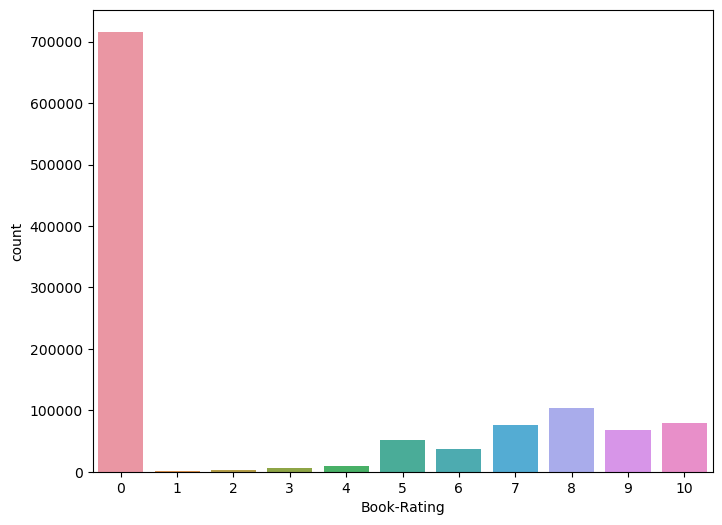

In [50]:
plt.figure(figsize=(8,6))
sns.set_palette("pastel")
sns.countplot(x="Book-Rating", data=df_ratings)

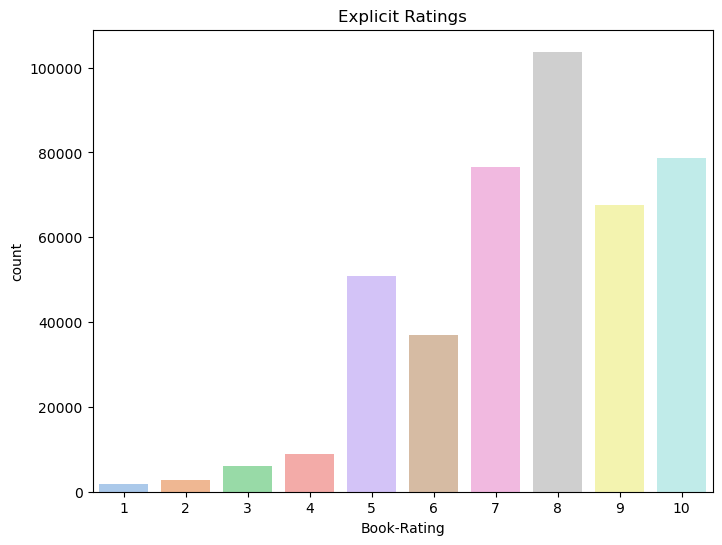

In [51]:
## Explicit Ratings
plt.figure(figsize=(8,6))
sns.set_palette("pastel")
sns.countplot(x="Book-Rating", data= df_ratings[df_ratings['Book-Rating'] != 0])
plt.title("Explicit Ratings");

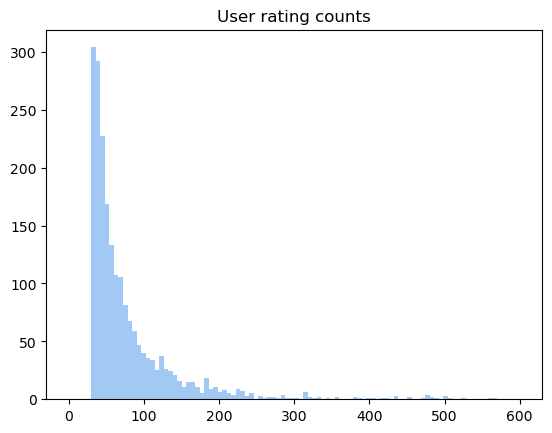

In [52]:
plt.hist(counts1.loc[counts1['Count'] > 30].Count.tolist(), bins = 100,range=[0, 600])
plt.title("User rating counts");

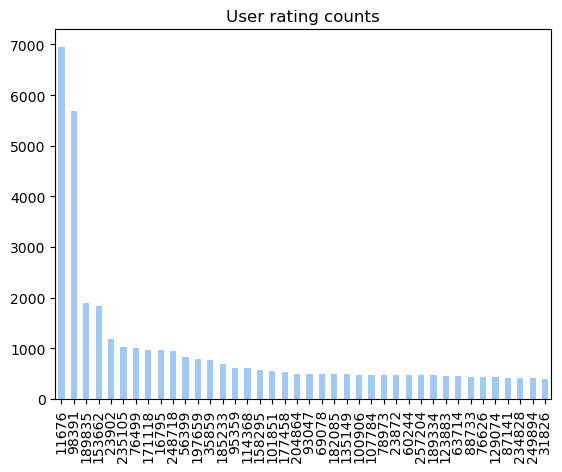

In [53]:
data1['User-ID'].value_counts()[:40].plot(kind='bar')
plt.title("User rating counts");

Text(0.5, 1.0, 'Top 10 number of readers from each country ')

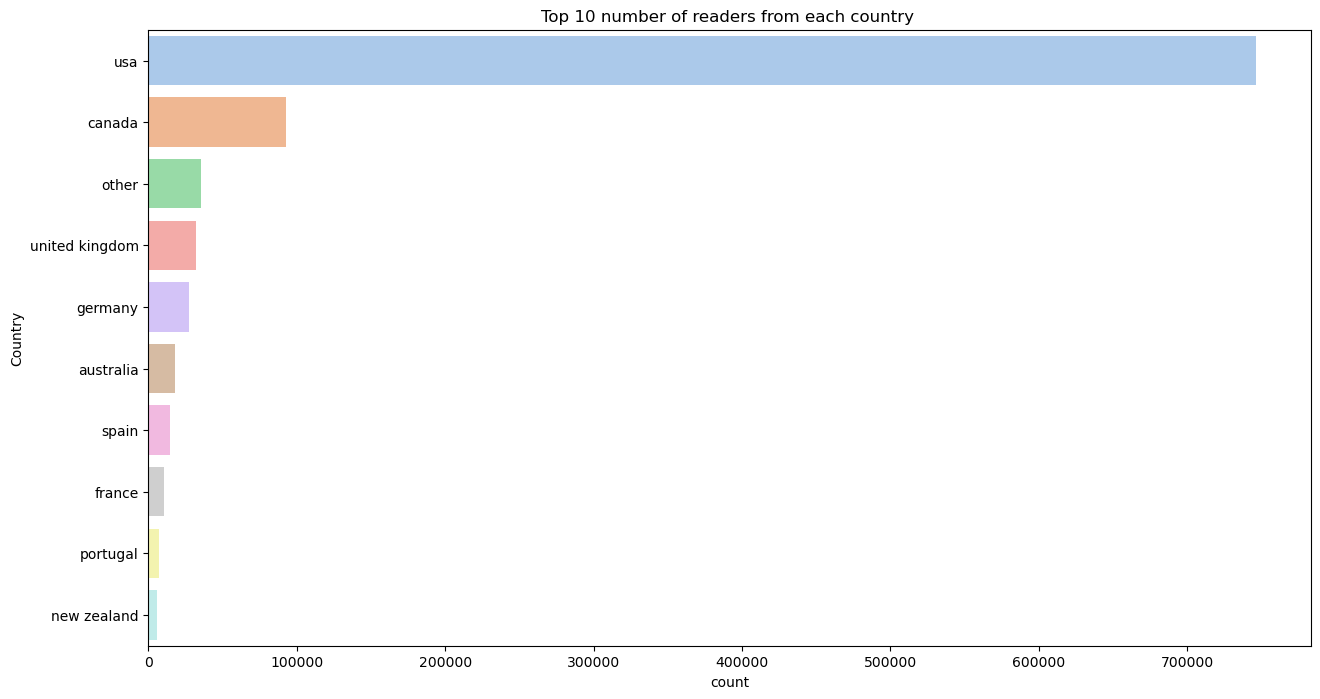

In [54]:
plt.figure(figsize=(15,8))
sns.set_palette("pastel")
sns.countplot(y="Country", data=data, order=data['Country'].value_counts().index[0:10])
plt.title("Top 10 number of readers from each country ")

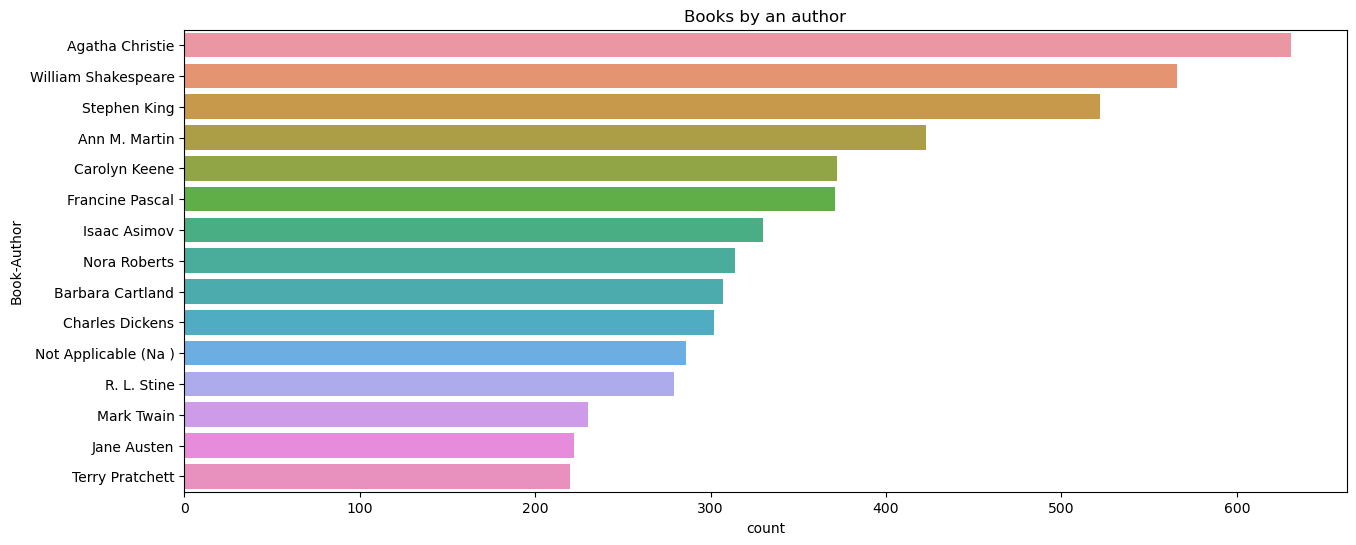

In [55]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=df_books,order=df_books['Book-Author'].value_counts().index[0:15])
plt.title("Books by an author");

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

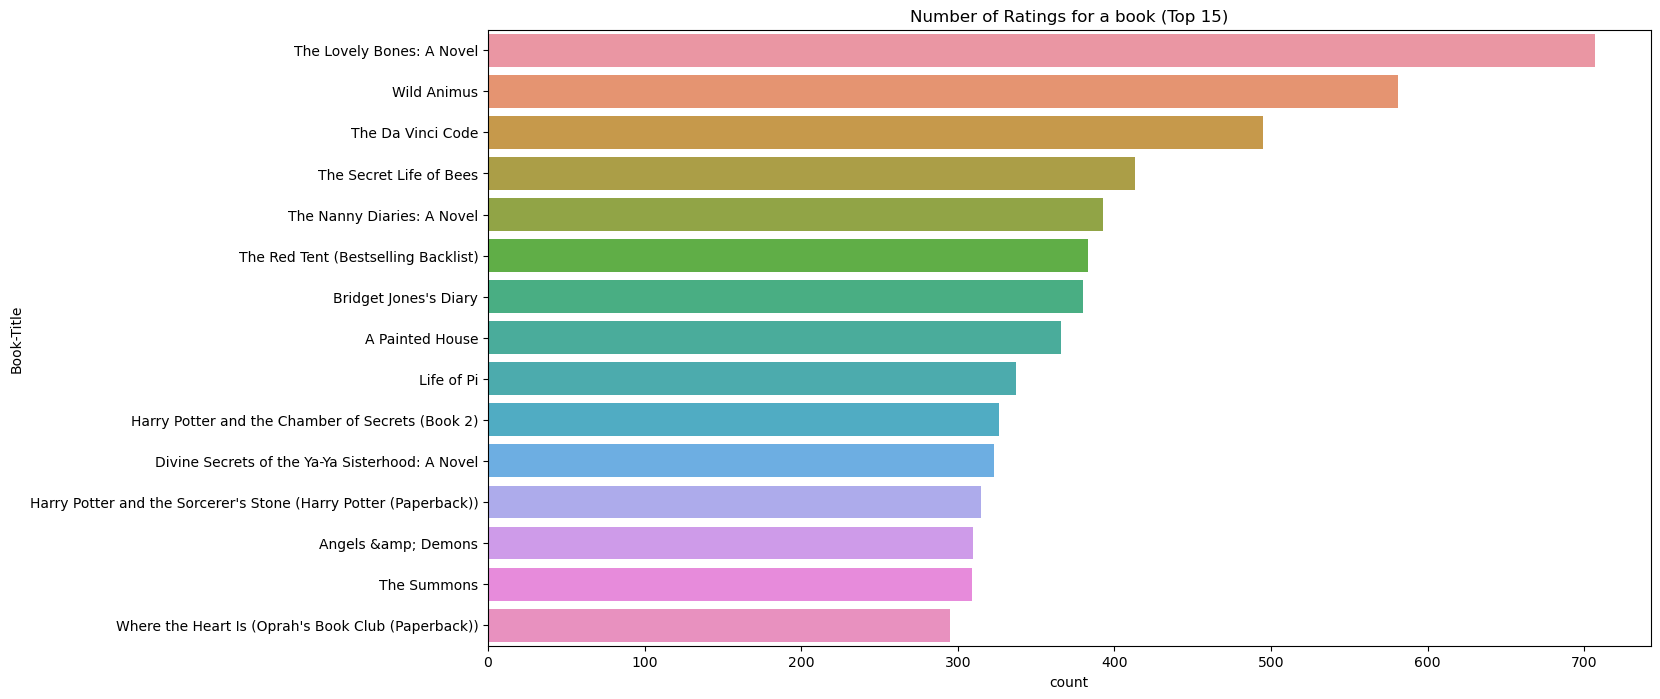

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=data1, order=data1['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

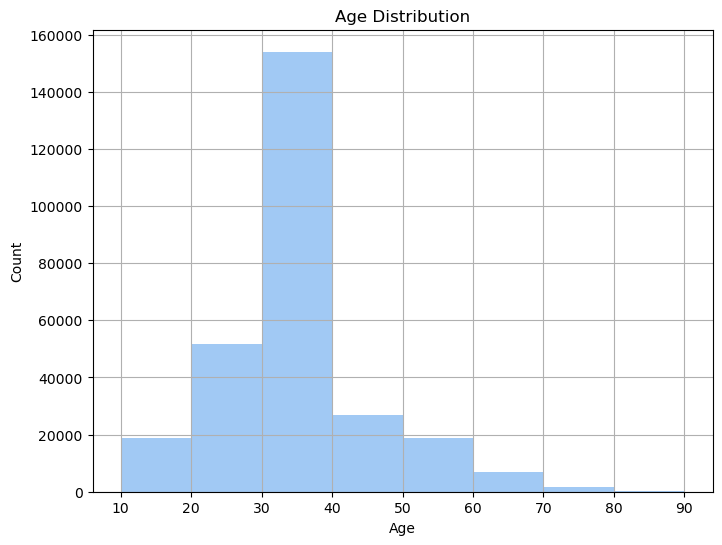

In [57]:
plt.figure(figsize=(8,6))
df_users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

## Building recommendation system 💻
- Recommendation based on the same author + weighted average
- User-ID-Book matrix with ratings -> KNN
- NLP

In [79]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

#Lord of the Rings Trilogy
#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
#The Two Towers (The Lord of the Rings, Part 2)
#Anglo-American Cataloguing Rules

Enter a book name:  Anglo-American Cataloguing Rules
Enter number of books to recommend:  10


In [59]:
def avgRating(newdf, df):
    newdf['Average Rating'] = 0
    for x in range(len(newdf)):
        l = list(df.loc[df['Book-Title'] == newdf['Book-Title'][x]]['Book-Rating'])
        newdf['Average Rating'][x] = sum(l)/len(l)
    return newdf

In [60]:
#df = pd.DataFrame(data1['Book-Title'].value_counts())
#df['Total-Ratings'] = df['Book-Title']
#df['Book-Title'] = df.index
#df.reset_index(level=0, inplace=True)
#df = df.drop('index',axis=1)
#df = avgRating(df, data1)
#df.to_pickle('weightedData')

In [61]:
df = pd.read_pickle('weightedData')
df

,Book-Title,Total-Ratings,Average Rating
0,The Lovely Bones: A Novel,707,8.185290
1,Wild Animus,581,4.390706
2,The Da Vinci Code,495,8.430303
3,The Secret Life of Bees,413,8.479419
4,The Nanny Diaries: A Novel,393,7.437659
...,...,...,...
135586,Pearl Buck's the Good Earth,1,5.000000
135587,Pearl S. Buck's Book of Christmas (G K Hall La...,1,5.000000
135588,"Pearl S. Buck, the Story Bible",1,5.000000
135589,Mrs. Malory and Death in Practice (Sheila Malo...,1,8.000000


In [62]:
#C - Mean vote across the whole
C = df['Average Rating'].mean()

#Minimum number of votes required to be in the chart
m = df['Total-Ratings'].quantile(0.90)

In [63]:
C,m

(7.522866770689833, 5.0)

In [64]:
def weighted_rating(x, m=m, C=C): 
    v = x['Total-Ratings']    #v - number of votes
    R = x['Average Rating']   #R - Average Rating   
    return (v/(v+m) * R) + (m/(m+v) * C)

$$
WeightedRating = (\tfrac{v}{v+m} \times R) + (\tfrac{m}{m+v} \times C)
$$

In [65]:
#df = df.loc[df['Total-Ratings'] >= m]
df['Score'] = df.apply(weighted_rating, axis=1)
df = df.sort_values('Score', ascending=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135591 entries, 1877 to 1
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Book-Title      135591 non-null  object 
 1   Total-Ratings   135591 non-null  int64  
 2   Average Rating  135591 non-null  float64
 3   Score           135591 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.2+ MB


In [66]:
data1['Score'] = data1['Book-Title'].map(df.set_index('Book-Title')['Score'])
data1['Total-Ratings'] = data1['Book-Title'].map(df.set_index('Book-Title')['Total-Ratings'])

In [72]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    y = k['Image-URL-L'].unique()
    for x in range(len(z)):
        print(z[x])
        try:
            display(Image(url= y[x], width=100))
        except:
            pass
        if x >= n-1:
            break

In [68]:
def get_books(dataframe, name, n):
    #print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = data1[data1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
        print(type(k2))
    k2 = k2.sort_values(by=['Score'], ascending = False)
    printBook(k2, n)

In [73]:
#n
def get_books(author, n, data):
    if author in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == author]
        k2 = k2.sort_values(by=['Score'], ascending = False)
        printBook(k2, n)
    else:
        print('No more books from the same author')

In [78]:
#n
#Recommend books with the same author
print(f'Recommended Top {number} books for {bookName}:\n')
if bookName in list(data1['Book-Title'].unique()):
    author = data1[data1['Book-Title'] == bookName]['Book-Author'].tolist()[0]
    data = data1[data1['Book-Title'] != bookName]
    get_books(author, number, data)
else:
    print("Invalid Book Name!!")

Recommended Top 10 books for Lord of the Rings Trilogy:

The Two Towers (The Lord of the Rings, Part 2)


The Return of the King (The Lord of the Rings, Part 3)


The Hobbit


The Lord of the Rings (Movie Art Cover)


The Fellowship of the Ring (The Lord of the Rings, Part 1)


The Fellowship of the Ring (Lord of the Rings (Paperback))


The Hobbit: or There and Back Again


The Return of the King (Lord of the Rings (Paperback))


The Return of the King (The Lord of the Rings Part 3)


The Silmarillion


In [76]:
#n
#Recommend books with the same author
print(f'Recommended Top {number} books for {bookName}:\n')
if bookName in list(data1['Book-Title'].unique()):
    author = data1[data1['Book-Title'] == bookName]['Book-Author'].tolist()[0]
    data = data1[data1['Book-Title'] != bookName]
    get_books(author, number, data)
else:
    print("Invalid Book Name!!")

Recommended Top 10 books for Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)):

Harry Potter and the Chamber of Secrets Postcard Book


Harry Potter and the Goblet of Fire (Book 4)


Harry Potter and the Sorcerer's Stone (Book 1)


Harry Potter and the Prisoner of Azkaban (Book 3)


Harry Potter and the Order of the Phoenix (Book 5)


Harry Potter und der Gefangene von Azkaban


Harry Potter and the Chamber of Secrets (Book 2)


Harry Potter y el prisionero de Azkaban


Harry Potter et la chambre des secrets


Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)


In [80]:
#n
#Recommend books with the same author
print(f'Recommended Top {number} books for {bookName}:\n')
if bookName in list(data1['Book-Title'].unique()):
    author = data1[data1['Book-Title'] == bookName]['Book-Author'].tolist()[0]
    data = data1[data1['Book-Title'] != bookName]
    get_books(author, number, data)
else:
    print("Invalid Book Name!!")

Recommended Top 10 books for Anglo-American Cataloguing Rules:

No more books from the same author


<div class="alert alert-block alert-success">  
<b>➕ 
computationally simple 
</div>

<div class="alert alert-block alert-danger">  
<b>➖ 
very naive, not personalized approach
</div>

-------------------------------------

### Collaborative filtering KNN 

In [88]:
popularity_threshold = 5
data_result = data1[data1['Total-Ratings'] >= popularity_threshold]
data_result = data_result.reset_index(drop = True)

In [89]:
data_result

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country,Score,Total-Ratings
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5,35,timmins,ontario,canada,7.615310,9
1,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,11400,9,49,ottawa,ontario,canada,8.010499,244
2,0151008116,Life of Pi,Yann Martel,2002,Harcourt,http://images.amazon.com/images/P/0151008116.0...,11400,6,49,ottawa,ontario,canada,8.069048,337
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,11400,7,49,ottawa,ontario,canada,8.174264,383
4,0316789089,The Pilot's Wife : A Novel Tag: Author of the ...,Anita Shreve,1999,"Little, Brown",http://images.amazon.com/images/P/0316789089.0...,11400,7,49,ottawa,ontario,canada,7.737348,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210897,034539092X,The Great Train Robbery,Michael Crichton,1995,Ballantine Books,http://images.amazon.com/images/P/034539092X.0...,35508,8,35,edmonton,alberta,canada,7.843369,23
210898,034539092X,The Great Train Robbery,Michael Crichton,1995,Ballantine Books,http://images.amazon.com/images/P/034539092X.0...,108362,5,35,atlanta,georgia,usa,7.843369,23
210899,1853716154,Lucy Sullivan Is Getting Married,Marian Keyes,1996,Poolbeg Pr Ltd,http://images.amazon.com/images/P/1853716154.0...,243368,2,35,alkmaar,noordholland,netherlands,7.100398,31
210900,0152049266,The Window,Jeanette Ingold,2003,Harcourt Paperbacks,http://images.amazon.com/images/P/0152049266.0...,245444,8,18,linclon,nebraska,usa,7.161433,5


In [90]:
matrix = data_result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)
matrix

User-ID,8,9,16,17,19,26,32,39,42,44,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Lamb to the Slaughter and Other Stories (Penguin 60s S.)""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Yo!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iI Paradiso Degli Orchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
one hundred years of solitude,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
model.fit(up_matrix)

NearestNeighbors(metric='cosine')

In [103]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

#Lord of the Rings Trilogy
#Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
#The Two Towers (The Lord of the Rings, Part 2)
#Anglo-American Cataloguing Rules
#The Catcher in the Rye

Enter a book name:  The Catcher in the Rye
Enter number of books to recommend:  10


In [94]:
print(f'Recommended Top {number} books for {bookName}\n')
try:
    distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
    for i in range(0, len(distances.flatten())):
        if i > 0:
            print(matrix.index[indices.flatten()[i]])
            try: 
                display(Image(url= data1[data1['Book-Title'] == matrix.index[indices.flatten()[i]]]['Image-URL-L'].values[0], width=100))
            except:
                pass
except:
    print(f'It does not have enough ratings to be included in the model')

Recommended Top 10 books for The Two Towers (The Lord of the Rings, Part 2)

The Return of the King (The Lord of the Rings, Part 3)


The Fellowship of the Ring (The Lord of the Rings, Part 1)


The Return of the King (The Lord of The Rings, Part 3)


The Hobbit : The Enchanting Prelude to The Lord of the Rings


The Hobbit: or There and Back Again


Foundation and Empire (Foundation Novels (Paperback))


Second Foundation (Foundation Novels (Paperback))


Howliday Inn


The Fellowship of the Ring (Lord of the Rings (Paperback))


The Magician's Nephew (rpkg) (Narnia)


In [96]:
print(f'Recommended Top {number} books for {bookName}\n')
try:
    distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
    for i in range(0, len(distances.flatten())):
        if i > 0:
            print(matrix.index[indices.flatten()[i]])
            try: 
                display(Image(url= data1[data1['Book-Title'] == matrix.index[indices.flatten()[i]]]['Image-URL-L'].values[0], width=100))
            except:
                pass
except:
    print(f'It does not have enough ratings to be included in the model')

Recommended Top 10 books for Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Harry Potter and the Chamber of Secrets (Book 2)


Harry Potter and the Prisoner of Azkaban (Book 3)


Harry Potter and the Goblet of Fire (Book 4)


Harry Potter and the Order of the Phoenix (Book 5)


Lover Beware


Free Drinks for Ladies With Nuts: Delightfully Mangled English from Around the World


The Sorcerer's Companion: A Guide to the Magical World of Harry Potter


Tantalizing  (Blaze) (Harlequin Temptation, 715)


Anne of Ingleside (Anne of Green Gables Novels (Paperback))


Howliday Inn


In [104]:
print(f'Recommended Top {number} books for {bookName}')
try:
    distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
    for i in range(0, len(distances.flatten())):
        if i > 0:
            print(matrix.index[indices.flatten()[i]])
            try: 
                display(Image(url= data1[data1['Book-Title'] == matrix.index[indices.flatten()[i]]]['Image-URL-L'].values[0], width=100))
            except:
                pass
except:
    print(f'It does not have enough ratings to be included in the model')

Recommended Top 10 books for The Catcher in the Rye
Of Love and Other Demons (Penguin Great Books of the 20th Century)


Hamlet (Folger Shakespeare Library)


The Mambo Kings Play Songs of Love


To Kill a Mockingbird


Brave New World


Lord of the Flies


The Great Gatsby


Animal Farm


1984


Sputnik Sweetheart: A Novel


<div class="alert alert-block alert-success">  
<b>➕ 
simplicity, easy implementation, robustness
</div>

<div class="alert alert-block alert-danger">  
<b>➖  scalability - can be computationally expensive ( -> not many books are included), popularity bias, lack of personalization, depended on user interactions
</div>

### Other ideas
 - Wanted to try NLP aproach but did not have enough data -> download more data -> Tfidf, Word2Vec, SentenceBert

In [296]:
df_books_more = pd.read_csv('books_more.csv',on_bad_lines='skip',low_memory=False)
df_books_more

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.000,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.744,0002005018,5,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.744,0002005018,8,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.744,0002005018,0,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031170,1031170,278851,"dallas, texas, usa",33.000,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000.000,Simon & Schuster,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,Golf lovers will revel in this collection of t...,en,['Humor'],dallas,texas,usa
1031171,1031171,278851,"dallas, texas, usa",33.000,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.000,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,A daring twist on the travel-adventure genre t...,en,['Nature'],dallas,texas,usa
1031172,1031172,278851,"dallas, texas, usa",33.000,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.000,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,9,9,9,dallas,texas,usa
1031173,1031173,278851,"dallas, texas, usa",33.000,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.000,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,These hilarious stories by the creator of publ...,en,['Fiction'],dallas,texas,usa


In [379]:
data_result1 = data_result1.drop_duplicates(subset='Book-Title', keep="first")
data_result1

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,User-ID,Book-Rating,Age,City,State,Country,Score,Total-Ratings
0,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,11400,9,49,ottawa,ontario,canada,8.010,244
1,0151008116,Life of Pi,Yann Martel,2002,Harcourt,http://images.amazon.com/images/P/0151008116.0...,11400,6,49,ottawa,ontario,canada,8.069,337
2,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,11400,7,49,ottawa,ontario,canada,8.174,383
3,0316789089,The Pilot's Wife : A Novel Tag: Author of the ...,Anita Shreve,1999,"Little, Brown",http://images.amazon.com/images/P/0316789089.0...,11400,7,49,ottawa,ontario,canada,7.737,65
4,014025448X,At Home in Mitford (The Mitford Years),Jan Karon,1996,Viking Books,http://images.amazon.com/images/P/014025448X.0...,11400,10,49,ottawa,ontario,canada,7.871,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119156,3442760003,Liebesleben,Zeruya Shalev,2002,Distribooks,http://images.amazon.com/images/P/3442760003.0...,245499,5,30,erkrath,nordrhein-westfalen,germany,6.756,13
136702,8807810212,D Amore E Ombra,Isabel Allende,2002,Transglobal Books Inc,http://images.amazon.com/images/P/8807810212.0...,195443,5,22,vicenza,veneto,italy,6.663,11
136995,884590184X,Siddharta Romanzo Versione Di M Mila,Hermann Hesse,2002,Adelphi Book Shop Ltd,http://images.amazon.com/images/P/884590184X.0...,203031,10,29,monza,lombardia,italy,7.892,17
150328,0142000981,Coal: A Human History,Barbara Freese,2004,Penguin USA (Paper),http://images.amazon.com/images/P/0142000981.0...,9557,7,16,cols,ohio,usa,5.484,19


In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode two sentences
query_embeding = ""
corpus_embedings = ""
query_embeding = model.encode(query_embeding, convert_to_tensor=True)
corpus_embedings = model.encode(corpus_embedings, convert_to_tensor=True)

# Calculate cosine similarity
cosine_similarity = util.pytorch_cos_sim(query_embeding, corpus_embedings)

#Recommend the best one

<div class="alert alert-block alert-success">  
<b>➕ diversity, personalization, no need of user interaction data

</div>

<div class="alert alert-block alert-danger">  
<b>➖  can be computationally expensive, multilingual challenges, complex, data quality dependency
</div>

### 2. Application architecture

In [4]:
def show_svg(filename):
    display(SVG(filename))

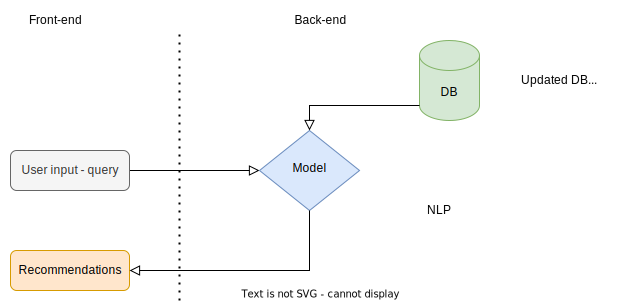

In [5]:
show_svg('NLP.drawio.svg')

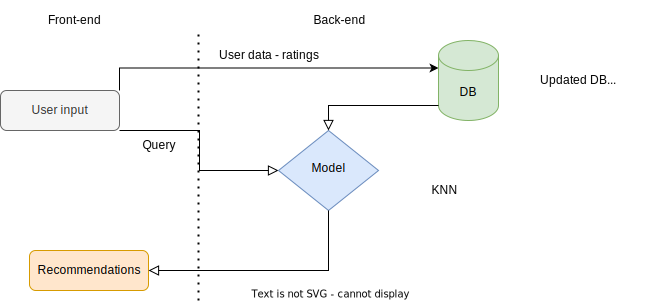

In [6]:
show_svg('KNN.drawio.svg')